# Próbne testy

w pewnym momencie w trialu zmienia się amplituda alfy w jakimś/kilku wybranym kanale

Rozmiar danych = (przykłady,kanały,próbki)

### Kod do chowania cellek

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

### Importy

In [2]:
import os
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from keras.layers import LSTM, Conv2D,Conv2DTranspose
from keras.layers import Activation, Conv3D, Conv3DTranspose
from keras.layers import Dropout, MaxPooling2D, MaxPooling3D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.utils import plot_model
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import scipy.signal as ss
from sklearn import preprocessing
import keras
from sklearn.model_selection import train_test_split
from keras.layers import ConvLSTM2D, BatchNormalization, SpatialDropout3D
from keras.utils import to_categorical

hide_toggle()

Using TensorFlow backend.


### Tworzenie danych

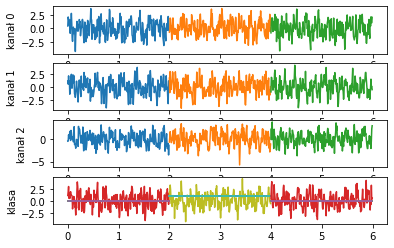

(6000, 19, 256)
(6000, 1)


In [4]:
Fs = 128 
T = 2
t = np.arange(0,T, 1/Fs)

nt = len(t) # liczba próbek w czasie jednego trialu
N = 3000 # liczba przykładów na klasę
k = 2 #liczba klas
channels  = 19 # liczba kanałów
freqs = (5,10,18)
chosen_channels = (2,6,7,11) #wybrane kanały w których pojawi się odpowiedź na pseudosłowo
A = 1.5

wersja_nietrenowalna = True #randomowe pojawianie się aktywności charakterystycznej dla pseudosłowa w słowach i dla różnych kanałów
wersja_trenowalna = False #aktywność charakterystyczna dla pseudosłowa o odpowiendnich kanałach


X = np.random.randn(k*N,channels,nt )
Y = np.zeros((k*N,1))

for tr in range(0,N*k,k):
    Y[tr,0] = 0
    Y[tr+1,0] = 1
    for ch in range(channels):
        s1 = np.sin(2*np.pi*(freqs[0]+(-0.6)*np.random.randn())*t)
        s2 = np.sin(2*np.pi*(freqs[1]+(-0.3)*np.random.randn())*t)
        s3 = np.sin(2*np.pi*(freqs[2]+(-0.8)*np.random.randn())*t)
        if ch in chosen_channels:
            # KLASA 0 - SLOWO
            if wersja_nietrenowalna:
                X[tr, ch, :] += s1 + s2 * (A * (-0.6)*np.random.randn() * np.random.randint(2) ) + s3
            elif wersja_trenowalna:
                X[tr, ch, :] += s1 + s2 + s3
            # KLASA 1 - PSEUDO
            X[tr+1, ch, :] += s1 + A*s2*(-0.6)*np.random.randn() + s3
        else: #wszystkie kanały poza wybranymi, aktywności nie widać
            if wersja_nietrenowalna:
                # KLASA 0 - SLOWO
                X[tr, ch, :] += s1 + s2* (A * (-0.6)*np.random.randn() * np.random.randint(2) ) + s3
                # KLASA 1 - PSEUDO
                X[tr+1, ch, :] += s1 + s2 * (A * (-0.6)*np.random.randn() * np.random.randint(2) ) + s3
            elif wersja_trenowalna:
                # KLASA 0 - SLOWO
                X[tr, ch, :] += s1 + s2 + s3
                # KLASA 1 - PSEUDO
                X[tr+1, ch, :] += s1 + s2 + s3

fig, ax = plt.subplots(4, 1)
for I_trial in range(3):
    for c in range(4):
        ax[c].plot( I_trial*nt/Fs+t, X[I_trial,c,:] )
        ax[c].set_ylabel('kanał '+str(c))
        ax[3].plot(I_trial*nt/Fs+t,Y[I_trial,]*np.ones(t.shape))
        ax[3].set_ylabel('klasa')

plt.show()
print(X.shape)
print(Y.shape)

hide_toggle()

### Obróbka danych i pakowanie do odpowiedniego kształtu 

In [5]:
X10_20 = np.zeros((X.shape[0],5,5,X.shape[2]))
X10_20[:,0,1,:] = X[:,0,:]
X10_20[:,0,3,:] = X[:,1,:]
X10_20[:,1,:,:] = X[:,2:7,:]
X10_20[:,2,:,:] = X[:,7:12,:]
X10_20[:,3,:,:] = X[:,12:17,:]
X10_20[:,4,1,:] = X[:,17,:]
X10_20[:,4,3,:] = X[:,18,:]

hide_toggle()

In [6]:
b_th , a_th = ss.butter(5, [0.1,8], btype='bandpass', analog=False, output='ba', fs=Fs)
b_al , a_al = ss.butter(5, [8,12], btype='bandpass', analog=False, output='ba', fs=Fs)
b_gm , a_gm = ss.butter(5, [12,30], btype='bandpass', analog=False, output='ba', fs=Fs)
X_theta = ss.filtfilt(b_th, a_th, X10_20, axis=-1)
X_alpha = ss.filtfilt(b_al, a_al, X10_20, axis=-1)
X_gamma = ss.filtfilt(b_gm, a_gm, X10_20, axis=-1)

hide_toggle()

In [7]:
X_fin = np.zeros((X.shape[0],5,5,X.shape[2],3))
X_fin[:,:,:,:,0] = X_theta
X_fin[:,:,:,:,1] = X_alpha
X_fin[:,:,:,:,2] = X_gamma
print(f'Rozmiar danych po obróbce: {X_fin.shape} = (triale, kanały, kanały, próbki, pasma)')



hide_toggle()

Rozmiar danych po obróbce: (6000, 5, 5, 256, 3) = (triale, kanały, kanały, próbki, pasma)


### Wrzucenie y do odpowiedniego formatu

In [8]:
y = to_categorical(Y).astype(np.integer)
hide_toggle()

In [9]:
X_fin1=np.einsum('ijklm->imljk',X_fin)

ind1 = np.arange(X_fin1.shape[0])
np.random.shuffle(ind1)
X_fin1 = X_fin1[ind1]
y1 = y[ind1]
# X_images.shape

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_fin1, y1, test_size=0.33, random_state=69)
print(f'Rozmiar danych treningowych: X = {X_train1.shape}, y = {y_train1.shape}')

hide_toggle()

Rozmiar danych treningowych: X = (4020, 3, 256, 5, 5), y = (4020, 2)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 3216 samples, validate on 804 samples
Epoch 1/30
3216/3216 [==============================] - 2s 546us/step - loss: 0.7072 - accuracy: 0.5090 - val_loss: 0.7123 - val_accuracy: 0.4838
Epoch 2/30
3216/3216 [==============================] - 1s 270us/step - loss: 0.6891 - accuracy: 0.5525 - val_loss: 0.7051 - val_accuracy: 0.5012
Epoch 3/30
3216/3216 [==============================] - 1s 275us/step - loss: 0.6786 - accuracy: 0.5740 - val_loss: 0.6971 - val_accuracy: 0.5037
Epoch 4/30
3216/3216 [==============================] - 1s 274us/step - loss: 0.6589 - accuracy: 0.6048 - val_loss: 0.6842 - val_accuracy: 0.5535
Epoch 5/30
3216/3216 [==============================] - 1s 270us/step - loss: 0.6357 - accuracy: 0.6545 - val_loss: 0.6657 - val_accuracy: 0.5933
Epoch 6/30
3216/3216 [=========================

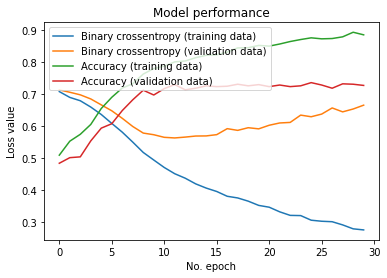

In [11]:
# del model

# Model configuration
batch_size = 100
no_epochs = 30
learning_rate = 0.001
no_classes = 2
validation_spl = 0.2
verbosity = 1
sample_shape = X_train1.shape[1:]


"""LSTMconv2D"""
model = Sequential()
model.add(ConvLSTM2D(filters = 15, kernel_size = (1,1), activation='tanh', dropout = 0.4, return_sequences = True, input_shape = sample_shape,data_format='channels_first'))
# model.add(BatchNormalization())
# model.add(SpatialDropout3D(1))
# model.add(Dense(10, activation='tanh'))
# model.add(ConvLSTM2D(filters = 3, kernel_size = (1,1), activation='tanh', dropout = 0.5, return_sequences = True))
# model.add(BatchNormalization())
model.add(Flatten())
# model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

# Compile the model
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

# Fit data to model
history = model.fit(X_train1, y_train1,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_spl)

# Generate generalization metrics
score = model.evaluate(X_test1, y_test1, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# Plot history: Binary crossentropy & Accuracy
plt.plot(history.history['loss'], label='Binary crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Binary crossentropy (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Model performance')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

hide_toggle()

In [12]:
w= model.get_weights()

In [13]:
print(f'liczba warst = {len(w)}')
for no,warstwa in enumerate(w):
    print(f'rozmiar warstwy {no} = {warstwa.shape}')

liczba warst = 5
rozmiar warstwy 0 = (1, 1, 256, 60)
rozmiar warstwy 1 = (1, 1, 15, 60)
rozmiar warstwy 2 = (60,)
rozmiar warstwy 3 = (1125, 2)
rozmiar warstwy 4 = (2,)


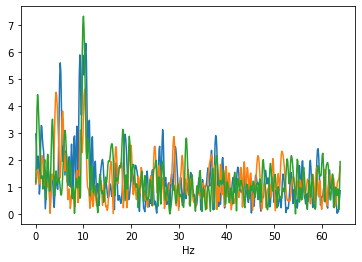

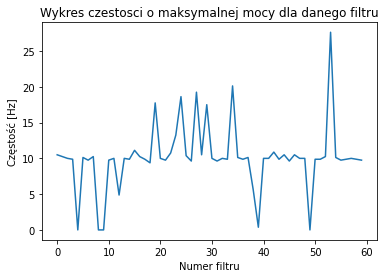

In [15]:
waga = w[0]
b = waga[0,0,:,0]
f, h0= ss.freqz(b, a=1, worN=512, whole=False,  fs=Fs)
b = waga[0,0,:,1]
f, h1= ss.freqz(b, a=1, worN=512, whole=False,  fs=Fs)
b = waga[0,0,:,2]
f, h2= ss.freqz(b, a=1, worN=512, whole=False,  fs=Fs)

plt.figure()
plt.plot(f, abs(h0))
plt.plot(f, abs(h1))
plt.plot(f, abs(h2))
plt.xlabel('Hz')
plt.show()

max_freqs=[]
for i in range(waga.shape[-1]):
    b = waga[0,0,:,i]
    f, h0 = ss.freqz(b, a=1, worN=512, whole=False,  fs=Fs)
    max_freqs.append(np.argmax(abs(h0))/8)
plt.plot(max_freqs)
plt.title("Wykres czestosci o maksymalnej mocy dla danego filtru")
plt.xlabel("Numer filtru")
plt.ylabel("Częstość [Hz]")
plt.show()